# Testing PyTorch's reparameterized gradients

@fritzo 2017-12-16

This currently requires the [test-rsample branch](https://github.com/probtorch/pytorch/tree/test-rsample) of PyTorch. To run this notebook you'll need to:
```sh
git clone git@github.com:probtorch/pytorch
cd pytorch
git checkout test-rsample
python setup.py build develop
jupyter notebook
```

In [1]:
import torch
from torch.autograd import Variable
from torch.distributions import Normal, Gamma, Beta
from torch.optim import Adam, SGD
from torch.nn import Softplus
import numpy as np
from matplotlib import pyplot
%matplotlib inline
torch.manual_seed(0)

In [2]:
softplus = Softplus()

Let's try to approximate a `Normal` distribution using `Gamma` and `Beta` distributions.

In [3]:
p = Normal(Variable(torch.Tensor([0.6])),
           Variable(torch.Tensor([0.1])))

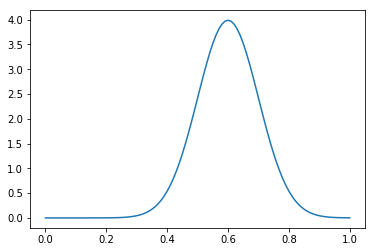

In [4]:
x = Variable(torch.arange(0,1,0.01))
pdf = torch.exp(p.log_prob(x))
pyplot.plot(x.numpy(), pdf.numpy())

## Fitting a Gamma distribution

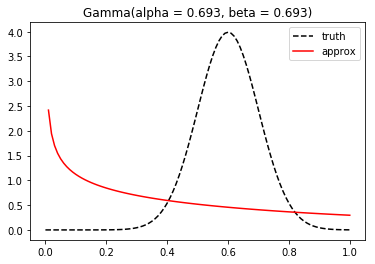

In [5]:
pre_alpha = Variable(torch.Tensor([0]), requires_grad=True)
pre_beta = Variable(torch.Tensor([0]), requires_grad=True)

def plot_qp(q):
    pyplot.plot(x.data.numpy(), torch.exp(p.log_prob(x)).data.numpy(), 'k--', label='truth')
    pyplot.plot(x.data.numpy(), torch.exp(q.log_prob(x)).data.numpy(), 'r-', label='approx')
    pyplot.title('Gamma(alpha = {:0.3g}, beta = {:0.3g})'.format(softplus(pre_alpha).data[0],
                                                                 softplus(pre_beta).data[0]))
    pyplot.legend()

q = Gamma(softplus(pre_alpha), softplus(pre_beta))
plot_qp(q)

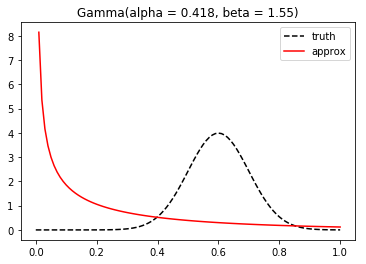

In [6]:
optim = Adam([pre_alpha, pre_beta], lr=0.1)
for _ in range(100):
    optim.zero_grad()
    q = Gamma(softplus(pre_alpha), softplus(pre_beta))
    z = q.rsample()
    kl = q.log_prob(z) - p.log_prob(z)
    kl.backward()
    if np.isfinite(pre_alpha.grad.data[0]) and np.isfinite(pre_beta.grad.data[0]):
        optim.step()
plot_qp(q)

## Fitting a Beta distribution

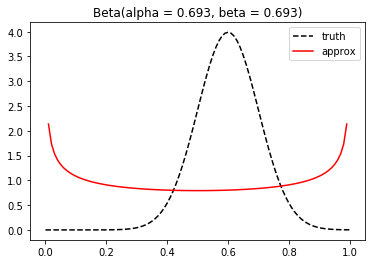

In [7]:
pre_alpha = Variable(torch.Tensor([0]), requires_grad=True)
pre_beta = Variable(torch.Tensor([0]), requires_grad=True)

def plot_qp(q):
    pyplot.plot(x.data.numpy(), torch.exp(p.log_prob(x)).data.numpy(), 'k--', label='truth')
    pyplot.plot(x.data.numpy(), torch.exp(q.log_prob(x)).data.numpy(), 'r-', label='approx')
    pyplot.title('Beta(alpha = {:0.3g}, beta = {:0.3g})'.format(softplus(pre_alpha).data[0],
                                                                softplus(pre_beta).data[0]))
    pyplot.legend()

q = Beta(softplus(pre_alpha), softplus(pre_beta))
plot_qp(q)

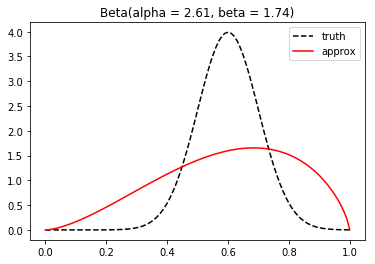

In [8]:
optim = Adam([pre_alpha, pre_beta], lr=0.1)
for _ in range(100):
    optim.zero_grad()
    q = Beta(softplus(pre_alpha), softplus(pre_beta))
    z = q.rsample()
    kl = q.log_prob(z) - p.log_prob(z)
    kl.backward()
    if np.isfinite(pre_alpha.grad.data[0]) and np.isfinite(pre_beta.grad.data[0]):
        optim.step()
    #pyplot.plot(x.data.numpy(), torch.exp(q.log_prob(x)).data.numpy(), 'r-', alpha=0.1)
plot_qp(q)